# Prédiction de la qualité d'un film à partir de ses caractéristiques

**Note importante :** \
Si vous lisez ce Notebook depuis l'interface GitHub, vous ne pourrez pas accéder à tout son contenu. Pour le visualiser en intégralité, nous vous invitons à vous rendre sur ce lien : https://nbviewer.org/github/Jeremstar/Succes_de_films-IMDb/blob/main/Notebook/Scrap_IMDb.ipynb \
Par ailleurs, si vous souhaitez exécuter le code, vous ne pourrez pas lancer le scraping (sauf à vous restreindre à un nombre limité de pages scrapées). Ce code est réalisé en conséquence. La base de donnée issue de notre scraping est disponible par téléchargement, ce que nous avons évidemment intégré à la rédaction.

## Présentation du projet
Le but de notre projet est de créer un modèle économétrique pour prédire le succès d'un film à partir de ses caractéristiques, comme sa durée, son genre, son réalisateur, etc. 

Nous avons décidé d'utiliser les données d'IMDb, un site de notation et de référencement des films. L'avantage de cette plateforme est qu'elle permet aux internautes de noter les films qu'ils ont vu, ce qui sera ce que l'on considère comme la mesure du succès d'un film. Par ailleurs, de nombreuses informations qui nous seront utiles sont présentes sur ce site et sont plus directement accessibles que sur une plateforme comme Wikipedia.

## Commençons par la mise en place du jeu de données
Nous importons une base mise à disposition par IMDb, que nous rendons exploitable par quelques opérations élémentaires.
Nous ne conservons que les films qui ont 2.000 votes ou plus : cela permet d'une part d'éviter de considérer les films trop peu votés pour que leur note moyenne soit pertinente, et d'autre part d'avoir un jeu de données plus léger.

In [1]:
import pandas as pd
movies_rating = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz")
movies_rating_clean = movies_rating["tconst\taverageRating\tnumVotes"].str.split("\\t", expand=True)
movies_rating_clean.columns = ['ID', 'Note_moyenne', 'Nombre_de_votes']
movies_rating_clean['Note_moyenne'] = movies_rating_clean['Note_moyenne'].astype(float)
movies_rating_clean['Nombre_de_votes'] = movies_rating_clean['Nombre_de_votes'].astype(float)
movies_rating_filtré = movies_rating_clean[movies_rating_clean.Nombre_de_votes > 1999]

**Nous voilà maintenant en possession d'une première base de travail**

Le problème de ce jeu de donné téléchargé, c'est qu'il ne contient que des informations sur les votes des films. Il n'y a aucune mention d'autres caractéristiques dont nous pourrons avoir besoin, comme son cast. Nous avons contacté les services d'IMDb, mais leur API est payant... Nous avons donc choisi de scraper les informations dont nous avons besoin.

Cela dit, la base téléchargée va nous être particulièrement utile ! Nous avons à disposition les identifiants de tous les films de la plateforme qui ont recueilli 2000 votes ou plus, et l'URL des pages des films s'écrit à partir de cet identifiant.

In [2]:
#On fabrique le squelette du dataframe que l'on va remplir au fur et à mesure du scrap ; on le fusionnera par la suite
#avec la database téléchargée plus tôt
#On indique le nom des colonnes, qui sont les variables que l'on choisit de conserver
#contentRating est la classification d'age, creator est la société de production
df = pd.DataFrame(columns=['name', 'alternateName', 'url', 'contentRating', 'datePublished', 'genre', 'actor', 'director',
                           'creator', 'Origine', 'Budget', 'duration', 'keywords'])

**La soupe à la grimace**


Après avoir essayé de scraper les éléments en cherchant des chemins d'accès manuellement dans le code HTML rendu sous forme de "soupe" par BeautifulSoup, nous avons trouvé dans chaque page un dictionnaire qui comprend les caractéristiques principales des films. Le code suivant permet de recueillir ces données, les traiter pour les rendre exploitables, et les insérer dans un dataframe.

Nous avions des ambitions assez importantes quant aux variables à retenir, mais certains éléments étaient intraçables dans la soupe que nous donne BeautifulSoup, étant donné que la fonction de recherche dans la soupe n'autorise que 6 arguments de path, ce qui est largement insuffisant au vu de la structure des pages IMDb (et nous pensons que cette architecture a été volontairement établie pour rediriger les scrapeurs vers l'API d'IMDb). Le dictionnaire que nous pouvons scraper ne contient malheureusement pas des données comme le budget, la langue d'origine, etc... ce qui expliquera le retrait de certaines colonnes, et de nombreuses interrogations lors de la visualisation des données.

Malgré tout, le code suivant permet d'obtenir les caractéristiques de quelques 46.000 pages IMDb.

ATTENTION : si vous souhaitez faire fonctionner ce code, modifiez-le pour ne considérer que quelques pages (bouclez sur moins d'ID). Il est impossible d'obtenir le résultat de ce scrap dans un temps raisonnable.

In [ ]:
from bs4 import BeautifulSoup as bs
import requests
from random import seed
import time
import json
import re


#C'est une liste des objets inutiles dans le scrap des pages ; je retire aussi le contenu du dataframe
#qu'on a déjà (les votes)
superflu = ["@context", "@type", "image", "description", "review", "trailer", "aggregateRating"]
#Celui-ci servira à retirer les images des scénaristes, etc
superflu2 = ['@type', 'url']

session_obj = requests.Session()


#On boucle sur chaque film qu'on considère
#Le compteur est cosmétique : il sert à nous rassurer sur le fait que tout se passe bien pendant le scrap
compteur = 0
for ID in movies_rating_filtré['ID'] :
  compteur = compteur+1
  print(compteur)
  try: #On utilise un try except au cas où on aurait un problème sur une page :
    #on ne veut pas que l'exécution s'arrête après des heures de scrap
    time.sleep(0.01) #On ajoute un petit délai pour ne pas surcharger le site de requêtes
    url_temp = 'https://www.imdb.com/title/'+ID+'/'
    response=session_obj.get(url_temp, headers={"User-Agent": "Mozilla/5.0"}) #On se fait passer pour une session normale 
    html = response.content
    soup = bs(html, "html.parser")
    
    #Le bloc est composé de la partie de chaque page qui contient les informations utiles
    #On le transforme en dictionnaire
    bloc = soup.find("script", type="application/ld+json").string
    dictio = json.loads(bloc)
    
    #On retire dedans ce qui ne nous intéresse pas
    for inutile in superflu :
      dictio.pop(inutile, None)

    #on ajoute une ligne budget illico presto ATTENTION CA NE MARCHE PAS
    liste_budg = soup.find_all("label", class_="ipc-metadata-list-item__list-content-item")
    if len(liste_budg) >= 3 and '$' in liste_budg[2] :
      budget = liste_budg[2].string
      if budget == None :
        budget = "Non renseigné"
      else :
        budget = "".join([elemnt for elemnt in budget if elemnt.isdigit()])
      dictio['Budget'] = budget

    #L'allure du dictionnaire n'est pas parfaitement satisfaisante, par exemple chaque acteur est associé à
    #une date de naissance,à une photo, etc... On ne conserve que le nom des acteurs, et celui des réalisateurs
    
    if 'actor' in dictio :
      for acteur in dictio['actor'] :
        for inutile in superflu2 :
          acteur.pop(inutile, None)
      for indice, nom in enumerate(dictio['actor']) :
        dictio['actor'][indice] = nom['name']

    if 'director' in dictio :
      for directeur in dictio['director'] :
        for inutile in superflu2 :
          directeur.pop(inutile, None)
      for indice, nom in enumerate(dictio['director']) :
        dictio['director'][indice] = nom['name']
    
    if 'creator' in dictio :
      for createur in dictio['creator'] :
        createur.pop('@type', None)
      for indice, url in enumerate(dictio['creator']) :
        dictio['creator'][indice] = url['url']

    #Pour la société de production c'est un peu compliqué : on n'a qu'une URL
    #Ce qui n'est pas grave, puisqu'on peut retrouver son nom en scrapant cet url !
    #Mais le temps d'exécution explose si on le fait ; j'inclus donc ce code (complètement fonctionnel)
    #mais en pratique il prend trop de temps à tourner
    
    if 'creator' in dictio :
      for index, createur in enumerate(dictio['creator']) :
        url_temp = 'https://www.imdb.com'+createur
        response=session_obj.get(url_temp, headers={"User-Agent": "Mozilla/5.0"})
        html = response.content
        soup = bs(html, "lxml")
        compagnie_soup = soup.find("title")
        if compagnie_soup == None :
          compagnie = "Non renseigné"
        else :
          compagnie = compagnie_soup.string
        compagnie = compagnie[5:-40] #on garde que l'élément important du titre
        dictio['creator'][index] = compagnie

    #On ajoute au dictionnaire le pays d'origine, que l'on le trouve dans la date de sortie
    date_sortie_soup = soup.find("a",
    class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link",
                                 href="/title/"+ID+"/releaseinfo?ref_=tt_dt_rdat")
    if date_sortie_soup == None :
      date_sortieV2 = "Non renseigné"
      pays = "Non renseigné"
    else :
      date_sortieV2 = date_sortie_soup.string
      b1 = date_sortieV2.find('(')
      b2 = date_sortieV2.find(')')
      pays = date_sortieV2[b1:b2]
      pays=pays[1:]
    dictio['Origine'] = pays

    #On ajoute dans le dataframe la ligne qui correspond au film
    df = df.append(dictio, ignore_index=True)
  except:
    print('Erreur au rang : '+str(compteur))

**Et voilà : nous avons construit une base de donnée grâce au scraping**

Nous ne conseillons pas de lancer ce code, puisqu'il nous a fallu plus d'une journée pour obtenir le dataframe, sans compter toutes les fois où notre ordinateur a eu des problèmes de connexion et interrompu l'exécution (ce qui nous a coûté au total 3 jours). En revanche, il est possible de le lancer sur quelques valeurs, pour obtenir un échantillon.

Nous mettrons à disposition le dataframe complet, pour pouvoir lancer le reste du code sans scraper à nouveau ces 46.000 pages.

**La prochaine étape est donc de fusionner les dataframes et de transformer la classe des objets de chaque colonne, pour les rendre exploitables**

Le code suivant permet d'importer le dataframe du scrap (*df*) et de le fusionner avec le dataframe téléchargé et traité (*movies_rating_filtré*), en fabriquant une colonne commune pour permettre la jointure. On prend également le soin de rendre les éléments des colonnes *actor* et *director* comme des listes. Ce code fonctionne malgré l'avertissement qu'il renvoie.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Jeremstar/Succes_de_films-IMDb/main/Database/IMDB_2000votes.csv', 
                 converters={"actor": lambda x: x.strip("[]").split(", "),
                             'director': lambda y : y.strip("[]").split(", ")}) 

movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'
df_fusionné = df.merge(movies_rating_filtré, on='url',how='left')

/tmp/ipykernel_45639/560150336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'


On ordonne ensuite les colonnes dans l'ordre que l'on souhaite, on supprime celles qui posent problème.

In [3]:
df_fusionné = df_fusionné.reindex(columns=['ID_y','name','alternateName','url','contentRating',
                                           'datePublished','genre','actor','director','creator','Origine','Budget',
                                           'duration','keywords','Note_moyenne','Nombre_de_votes','ID_x'])
#On drop creator, pour les questions de scrap évoquées plus tôt, et budget parce qu'il est impossible de l'obtenir avec
#uniquement 6 arguments de path comme le permet la library de scrap
df_fusionné =df_fusionné.drop(['ID_x', 'Budget', 'alternateName', 'creator'],axis=1) 
df_fusionné.rename(columns={'ID_y':'ID'}, inplace= True)

Certaines chaînes de caractères ne sont pas lisibles (on a par exemple des codes "&apos ;" au lieu de véritables apostrophes).
La fonction suivante permet de résoudre ces problèmes, à la fois dans les listes et les string.

In [4]:
def correcteur(colonne, old, new) :
    if type(df_fusionné[colonne][0]) == list :
        all_crews = []
        for crew in df_fusionné[colonne]:
            crew_corrigé = []
            if crew != [] :
                for individu in crew :
                    crew_corrigé.append(individu.replace(old, new))
            all_crews.append(crew_corrigé)
        df_fusionné[colonne] = all_crews
    else :
        df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new)

On applique donc cette fonction de correction à toutes les colonnes qui en ont besoin.

In [5]:
#Précisons qu'une apostrophe apparaît dans le notebook à la place du code & apos; en deuxième argument de la fonction
#en réalité, il s'agit évidemment du code du caractère à remplacer.
correcteur('actor', '&apos;', "'")
correcteur('director', '&apos;', "'")
correcteur('name', '&apos;', "'")

Nous aurons par la suite recours souvent à une fonction qui permet d'obtenir toutes les valeurs uniques que contient une colonne, qu'elle contienne des listes ou des éléments simples. Elle a beaucoup servi dans notre travail de construction, donc nous la présentons pour que la démarche soit claire.

In [6]:
from pandas.core.common import flatten

def valeurs_possibles (colonne) :
    list_nonflat = df_fusionné[colonne]
    flat_list = list(flatten(list_nonflat))
    liste_valeurs = list(set(flat_list))
    return liste_valeurs

Grâce à cette fonction donc, nous pouvons harmoniser plus facilement les classifications d'âge des films.

In [25]:
valeurs_possibles('contentRating')

[nan,
 'M/PG',
 '-12',
 '13',
 'X',
 '(Banned)',
 '0+',
 '9+',
 'TV-Y7',
 'E',
 '12 avec avertissement',
 'Accord parental',
 '16 avec avertissement',
 'Not Rated',
 'TV-PG',
 'Unrated',
 '10 avec avertissement',
 'Passed',
 '12',
 'G',
 'Open',
 '10',
 'MA-17',
 'T',
 'TV-G',
 'Tous publics avec avertissement',
 '7',
 'AO',
 '14+',
 'TV-14',
 '-16',
 'E10+',
 'Approved',
 'R',
 'PG',
 'TV-Y7-FV',
 'PG-13',
 '16',
 'TV-MA',
 '-10',
 'GP',
 'M',
 'Tous Publics',
 'Tous publics',
 'TV-Y',
 'Public Averti',
 '18',
 'Tout public',
 'TV-13',
 'K-A',
 '6+',
 'Tous Public',
 'NC-17']

In [7]:
correcteur('contentRating', 'Tous Public', 'tous publics')
correcteur('contentRating', 'Tous Publics', 'tous publics')
correcteur('contentRating', 'Tous public', 'tous publics')
correcteur('contentRating', 'Tous publics', 'tous publics')
correcteur('contentRating', 'Not Rated', 'Not rated') #Absence de certificat
correcteur('contentRating', 'Unrated', 'Not rated') #Idem
correcteur('contentRating', '-12', '12')
correcteur('contentRating', '10 avec avertissement', '10')
correcteur('contentRating', '12 avec avertissement', '12')
correcteur('contentRating', 'Passed', 'Approved') #Classification d'avant 1968
correcteur('contentRating', '14+', '14')
correcteur('contentRating', '(Banned)', 'Banned')
correcteur('contentRating', '-16', '16')
correcteur('contentRating', 'TV-14', '14')
correcteur('contentRating', '16 avec avertissement', '16')
correcteur('contentRating', '-10', '10')
correcteur('contentRating', 'TV-PG', 'Accord parental')
correcteur('contentRating', 'PG-13', 'Accord parental')
correcteur('contentRating', 'M/PG', 'Accord parental')
correcteur('contentRating', 'PG', 'Accord parental')
correcteur('contentRating', '0+', 'tous publics')
correcteur('contentRating', 'E1Tous Publics+', 'tous publics')
correcteur('contentRating', 'E1Tous Public+', 'tous publics')
correcteur('contentRating', 'TV-13', '13')
correcteur('contentRating', 'R', '18')
correcteur('contentRating', 'GP', 'Accord parental')
correcteur('contentRating', 'MA-17', '17')
correcteur('contentRating', 'X', '18')
correcteur('contentRating', 'TV-Y7-FV', '7')
correcteur('contentRating', 'TV-Y7', '7')
correcteur('contentRating', 'TV-G', 'Tous Public')
correcteur('contentRating', 'G', 'Tous Public')
correcteur('contentRating', 'Tous Publics', 'tous publics')
correcteur('contentRating', 'Tout public', 'tous publics')
correcteur('contentRating', '1Tous Public', 'tous publics')
correcteur('contentRating', 'Tous Public+', 'tous publics')
correcteur('contentRating', 'NC-17', '18')
correcteur('contentRating', 'TV-MA', '18')
correcteur('contentRating', 'TV-T', 'tous publics')
correcteur('contentRating', 'M', '18')
correcteur('contentRating', 'E', 'Éducatif')
correcteur('contentRating', 'T', 'tous publics')
correcteur('contentRating', 'K-A', 'Erreur')
correcteur('contentRating', 'AO', 'Erreur')
correcteur('contentRating', 'Open', 'Erreur')
correcteur('contentRating', 'tous publicsV-Y', 'tous publics')
correcteur('contentRating', 'Éducatif1tous publics+', 'tous publics')
correcteur('contentRating', 'tous publicss avec avertissement', 'tous publics')
correcteur('contentRating', '1tous publics', 'tous publics')
correcteur('contentRating', 'tous publicss', 'tous publics')

/tmp/ipykernel_45639/534507345.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new)


Cette procédure est fastidieuse mais il est difficile de faire autrement pour harmoniser.

On convertit à présent les mois, pour les numéroter de 1 à 12.

In [8]:
df_fusionné['month'] = pd.DatetimeIndex(df_fusionné['datePublished']).month

On convertit ensuite la durée du film, pour passer par exemple de "PT1H32M" au nombre de minutes du film. Par souci de lisibilité, on construit d'abord une fonction de recodage, que l'on applique ensuite à la colonne.

In [9]:
def recodage_duree(duree) :
    if type(duree) == str :
        duree = duree[2:]
        if 'H' not in duree :
            duree_corrigee = int(duree[-3:-1])
        elif 'M' not in duree :
            duree_corrigee = int(duree[-2:-1])*60
        else :
            heures = int(duree[0])*60
            duree = duree[2:]
            minutes = int(duree[-3:-1])
            duree_corrigee = heures + minutes
    else :
        duree_corrigee = None
    return duree_corrigee

In [10]:
df_fusionné['duration']=df_fusionné['duration'].apply(lambda row : recodage_duree(row))

À présent, on transforme les dates avec un véritable format date. On fait le choix d'écarter les 700 films pour lesquels la date n'est pas renseignée, en considérant qu'ils sont minoritaires.

In [11]:
index_with_nan = df_fusionné.index[df_fusionné.loc[:,'datePublished'].isnull()]
df_fusionné.drop(index_with_nan,0, inplace=True)
df_fusionné = df_fusionné.sort_values(by='datePublished')
df_fusionné = df_fusionné.reset_index(drop = True)

/tmp/ipykernel_45639/2112836509.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_fusionné.drop(index_with_nan,0, inplace=True)


In [12]:
import datetime
df_fusionné['datePublished'] = df_fusionné['datePublished'].apply(lambda x : datetime.datetime.strptime(str(x), '%Y-%m-%d'))

**Le jeu de donné est à présent suffisamment propre pour être exploitable !** Affichons le pour voir son allure.

In [39]:
df_fusionné

['']

## Premier parcours du jeu de données : quelques statistiques descriptives

Commençons par établir quelques statistiques fondamentale pour avoir un aperçu un peu plus détaillé de la base de donnée. Gardons à l'esprit, pour cette partie et pour toutes celles qui suivront, que les résultats sont à interpréter avec précaution étant donné que nous n'avons retenu, arbitrairement, que les films qui ont reçu 2.000 votes ou plus.

In [15]:
df_fusionné[['Note_moyenne','Nombre_de_votes']].describe()

,Note_moyenne,Nombre_de_votes
count,46080.000000,4.608000e+04
mean,6.983800,2.523431e+04
std,1.303979,8.687819e+04
min,1.000000,2.000000e+03
25%,6.200000,2.903000e+03
50%,7.100000,4.705000e+03
75%,7.900000,1.255100e+04
max,10.000000,2.670872e+06


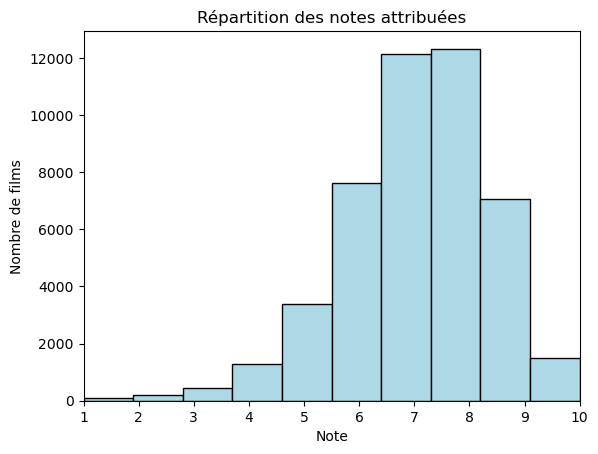

In [34]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(df_fusionné['Note_moyenne'], facecolor='lightblue', ec='black')
plt.xlabel('Note')
plt.ylabel('Nombre de films')
plt.title('Répartition des notes attribuées')
plt.xlim(1, 10)
plt.show()

Nous avons un total de 46.081 films, dont la note moyenne est d'un peu moins de 7 (un film "moyen" n'est donc pas noté 5). La moyenne du nombre de votes est de 2.500, ce qui indique que la majorité des films reçoivent peu de votes. De la même manière, en filtrant à 2.000 votes les films retenus, nous avions laissé de côté plus de la moitié des films. Cela correspond au phénomène de *long tail* : très peu de films reçoivent un grand nombre de votes, et beaucoup en reçoivent peu. De fait, le filtre de 2.000 vote nous prive d'une large variété de films, mais étant donnés nos moyens techniques, nous ne pouvons pas faire autrement, et le filtre est raisonnable.

In [23]:
df_fusionné.dropna(inplace = False)['duration'].describe()

count    34288.000000
mean        86.079007
std         36.304117
min          1.000000
25%         55.000000
50%         93.000000
75%        108.000000
max        583.000000
Name: duration, dtype: float64

Le film moyen de cette base de données dure 1h26. Le plus long dure presque 10h. Restons prudents en interprétant cette moyenne : une majorité de films de la fin du XIXe/début XXe sont des courts-métrages, comme l'indique le graphique suivant :

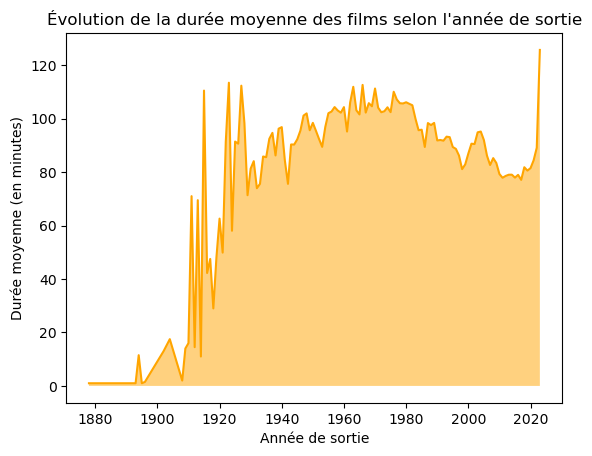

In [15]:
import math
# Sélectionnons les colonnes de durée et de date de sortie de votre dataframe
durations = df_fusionné['duration']
release_dates = df_fusionné['datePublished']

# Créons un dictionnaire qui contient les durées moyennes par année de sortie
average_durations = {}
for date, duration in zip(release_dates, durations):
    if not math.isnan(duration) :  # Vérifiez si la durée est renseignée
        year = date.year
        if year in average_durations:
            average_durations[year].append(duration)
        else:
            average_durations[year] = [duration]

# Calculons la durée moyenne pour chaque année de sortie
average_durations = {year: sum(durations)/len(durations) for year, durations in average_durations.items()}

# Récupérons les années et les durées moyennes pour tracer le graphique
years = list(average_durations.keys())
averages = list(average_durations.values())

# Créons la courbe
plt.plot(years, averages, color='orange')
plt.fill_between(years, averages, facecolor='orange', alpha=0.5)

# Ajoutons un titre et des noms aux axes
plt.xlabel('Année de sortie')
plt.ylabel('Durée moyenne (en minutes)')
plt.title('Évolution de la durée moyenne des films selon l\'année de sortie')

# Affichons le graphique
plt.show()

In [ ]:
df_fusionné.groupby('Origine').size()

On remarque que les pays avec le plus grand nombre de films sont la France et les États-Unis. Certains pays ont très peu de films recensés, comme l'Albanie. D'autres sont des pays disparus, comme la Yougoslavie. Essayons tout de même de représenter ces données sur une carte.

In [49]:
import geopandas
import folium

#On crée un df avec uniquement les origines et les notes du film
df_pays_note_indiv = df_fusionné.loc[:,['Origine', 'Note_moyenne']]
#On crée un df avec une seule occurence de chaque pays et la note moyenne associée
df_pays_moyenne = df_pays_note_indiv.groupby('Origine').count()
#On renomme pour que le module fonctionne bien
df_pays_moyenne = df_pays_moyenne.rename(index={'United States': 'United States of America'})
#On importe la base de données géopanda avec les cordonnées spatiales, il va falloir la fusionner avec notre dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#Fusion de notre base et de celle de geopanda
geopanda_et_nos_données = world.merge(df_pays_moyenne, how='left', left_on=['name'], right_on=['Origine'] )
#On ne garde que les pays où il y a une note
geopanda_et_nos_données = geopanda_et_nos_données.dropna(subset=['Note_moyenne']) 
carte_note_pays=folium.Map()
folium.Choropleth(
    geo_data=geopanda_et_nos_données,
    name='choropleth',
    data=geopanda_et_nos_données,
    columns=['name', 'Note_moyenne'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Nombre de films issus de ce pays'
).add_to(carte_note_pays)
carte_note_pays

**Mésaventures d'un scrapping malheureux, ou de l'utilité de la datavisualisation** \
C'est grâce à cette visualisation des données que nous nous appercevons d'une grande lacune de nos données. La France est effectivement un grand pays de cinéma, mais elle ne détrône pas les États-Unis. En réalité, les noms de pays que l'on a scrapé ne correspondent pas à l'origine d'un film. Ils proviennent d'une ligne qui indique leur date de sortie, et le pays associé à cette date. Le site semble détecter notre localisation, et afficher la date de sortie en France si le film connait une distribution internationale. L'origine d'*Harry Potter* est française par exemple. Autrement dit, en dehors de la France, les pays indiqués doivent être ceux des films qui connaissent une distribution exclusive à ce pays. 

Nous perdons donc à nouveau une variable d'intérêt, sauf à confondre films français et films à distribution internationale.

/tmp/ipykernel_35915/4169201609.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_christmas['month'] = df_christmas['datePublished'].dt.month


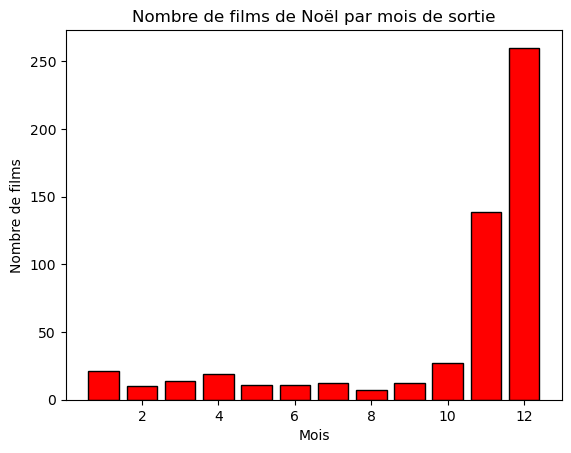

In [19]:
#films de noel

df_fusionné['keywords'] = df_fusionné['keywords'].fillna('')
# Filtrons le dataframe pour ne garder que les films qui ont le mot clé "christmas"
df_christmas = df_fusionné[df_fusionné['keywords'].str.contains('christmas')]

# Ajoutons une colonne qui contient le mois de sortie de chaque film
df_christmas['month'] = df_christmas['datePublished'].dt.month

# Groupby le dataframe par mois de sortie et comptez le nombre de films pour chaque mois
counts = df_christmas.groupby('month').size()

# Créons un graphique à barres avec matplotlib
plt.bar(counts.index, counts.values, facecolor='red', ec='black')
plt.xlabel('Mois')
plt.ylabel('Nombre de films')
plt.title('Nombre de films de Noël par mois de sortie')
plt.show()

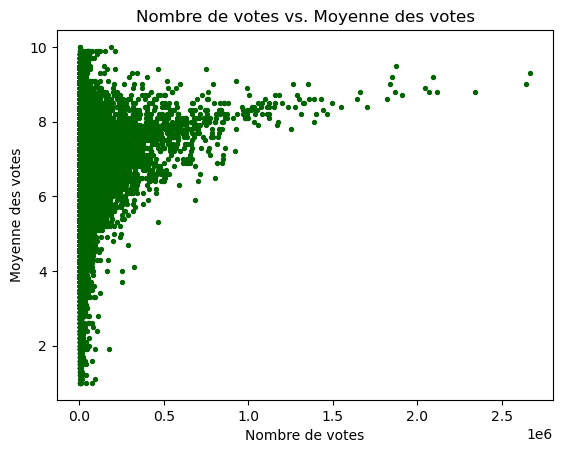

In [24]:
#Les films moins connus sont-ils mieux notés ?
df_fusionné.plot(x='Nombre_de_votes', y='Note_moyenne', kind='scatter', s=8, c='#006400')
plt.title("Nombre de votes vs. Moyenne des votes")
plt.xlabel("Nombre de votes")
plt.ylabel("Moyenne des votes")
plt.show()

LE CODE SUIVANT N'EST PAS ENTIEREMENT FONCTIONNEL
LE PREMIER BLOC FONCTIONNE BIEN, il crée le dictionnaire qui lie acteur et évolution de son score. il prend 10s max
LE DEUXIEME BLOC MARCHE PRESQUE, l'idée est top je trouve puisqu'elle permet une exécution très rapide. des problèmes de longueur de listes semblent subsister... affaire à suivre

In [45]:
df_fusionné = df_fusionné.sort_values(by='datePublished')
actor_scores = {}
for _, row in df_fusionné.iterrows():
    actors = row['actor']
    rating = row['Note_moyenne']
    for i, actor in enumerate(actors):
        if actor not in actor_scores:
            # Si l'acteur n'a joué dans aucun film précédemment, son score initial est de 5
            actor_scores[actor] = []
        new_score = (actor_scores[actor][-1] + rating * (i + 1)) / (i + 2) if actor_scores[actor] else 5
        actor_scores[actor].append(new_score)

In [46]:
actor_scores.pop('')

[5,
 5.95,
 6.825,
 7.112500000000001,
 7.65625,
 7.628125,
 7.2640625,
 7.532031249999999,
 7.616015624999999,
 6.4580078125,
 7.07900390625,
 5.389501953125,
 7.1447509765625,
 7.22237548828125,
 7.861187744140625,
 7.730593872070312,
 7.815296936035156,
 8.107648468017578,
 8.653824234008788,
 8.926912117004393,
 8.513456058502197,
 8.406728029251099,
 8.45336401462555,
 8.076682007312774,
 7.738341003656387,
 8.169170501828194,
 8.584585250914097,
 8.542292625457048,
 9.021146312728524,
 8.61057315636426,
 8.355286578182131,
 8.527643289091065,
 8.713821644545533,
 8.756910822272767,
 8.178455411136383,
 7.939227705568191,
 7.569613852784096,
 7.734806926392048,
 7.667403463196024,
 7.733701731598012,
 7.516850865799006,
 7.008425432899503,
 7.654212716449752,
 7.827106358224876,
 7.463553179112438,
 7.231776589556219,
 8.36588829477811,
 8.432944147389055,
 7.966472073694527,
 7.583236036847264,
 7.991618018423632,
 7.145809009211816,
 7.3229045046059085,
 7.511452252302954,
 7.45

In [ ]:
actor_scores

In [47]:
df_test = df_fusionné.copy()
as_test = actor_scores.copy()

In [48]:
df_test['liste_scores'] = None
def replace_empty_list(x):
    if x == ['']:
        return None
    return x

df_test['actor'] = df_test['actor'].apply(replace_empty_list)

In [ ]:
for index, row in df_test.iterrows():
    print(index)
    liste_scores = []
    if type(row['actor']) == list : 
        for acteur in row['actor']:
            liste_scores.append(as_test[acteur][0])
            as_test[acteur].pop(0)
        df_test.at[index, 'liste_scores'] = liste_scores
    else :
        df_test.at[index, 'liste_scores'] = None

In [50]:
df_test

,ID,name,url,contentRating,datePublished,genre,actor,director,Origine,duration,keywords,Note_moyenne,Nombre_de_votes,month,liste_scores
0,tt2221420,Sallie Gardner at a Gallop,/title/tt2221420/,tous publics,1878-06-15,"['Documentary', 'Short']","['Gilbert Domm', 'Sallie Gardner']",['Eadweard Muybridge'],United States,1.0,"19th century,1870s,nature,horse,first of its kind",7.4,3095.0,6.0,"[5, 5]"
1,tt0392728,Roundhay Garden Scene,/title/tt0392728/,Not rated,1888-10-14,"['Documentary', 'Short']","['Annie Hartley', 'Adolphe Le Prince', 'Joseph...",['Louis Aimé Augustin Le Prince'],United Kingdom,1.0,"place name in title,first of its kind,year 188...",7.3,6253.0,10.0,"[5, 5, 5]"
2,tt0000005,Blacksmith Scene,/title/tt0000005/,Not rated,1893-05-09,"['Short', 'Comedy']","['Charles Kayser', 'John Ott']",['William K.L. Dickson'],United States,1.0,"blacksmith,national film registry,beer,two wor...",6.2,2555.0,5.0,"[5, 5]"
3,tt0000008,Edison Kinetoscopic Record of a Sneeze,/title/tt0000008/,NaN,1894-01-09,"['Documentary', 'Short']",['Fred Ott'],['William K.L. Dickson'],United States,1.0,"national film registry,year 1894,1890s,19th ce...",5.4,2071.0,1.0,[5]
4,tt0177707,Dickson Experimental Sound Film,/title/tt0177707/,Not rated,1894-08-31,"['Short', 'Music']",['William K.L. Dickson'],['William K.L. Dickson'],United States,22.0,"same sex dance partners,gay interest,national ...",6.7,2378.0,8.0,[5]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46076,tt14208870,The Fabelmans,/title/tt14208870/,Accord parental,2023-01-25,['Drama'],"['Michelle Williams', 'Gabriel LaBelle', 'Paul...",['Steven Spielberg'],France,151.0,"arizona,coming of age,childhood,father son rel...",8.0,8800.0,1.0,"[7.046445428769727, 7.0, 8.012268418049125]"
46077,tt14444726,Tár,/title/tt14444726/,18,2023-02-22,"['Drama', 'Music']","['Cate Blanchett', 'Noémie Merlant', 'Nina Hoss']",['Todd Field'],France,158.0,"female rear nudity,classical music,character n...",7.8,11281.0,2.0,"[6.957289562944337, 7.529166666666666, 7.61215..."
46078,tt13833688,The Whale,/title/tt13833688/,18,2023-03-08,['Drama'],"['Brendan Fraser', 'Sadie Sink', 'Ty Simpkins']",['Darren Aronofsky'],France,117.0,"screenplay adapted by author,overweight man,ga...",8.3,5102.0,3.0,"[6.686173934024872, 7.766666666666667, 7.83125..."
46079,tt4960748,Till,/title/tt4960748/,Accord parental,2023-03-22,"['Biography', 'Drama', 'History']","['Danielle Deadwyler', 'Jalyn Hall', 'Frankie ...",['Chinonye Chukwu'],France,130.0,"year 1955,based on real people,1950s,justice,m...",7.2,3887.0,3.0,"[6.1, 5, 7.650438236258925]"


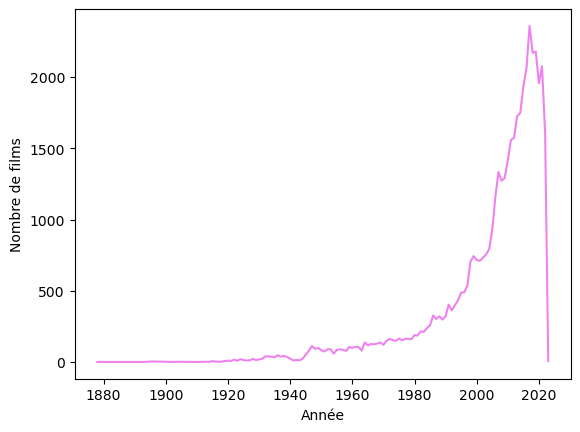

In [39]:
#nombre de films par année
films_par_annee = df_fusionné.groupby(df_fusionné["datePublished"].dt.year).size()
plt.plot(films_par_annee, color='violet')
plt.xlabel("Année")
plt.ylabel("Nombre de films")
plt.show()